In [1]:
!pip3 install transformers

  Obtaining dependency information for transformers from https://files.pythonhosted.org/packages/12/dd/f17b11a93a9ca27728e12512d167eb1281c151c4c6881d3ab59eb58f4127/transformers-4.35.2-py3-none-any.whl.metadata
  Using cached transformers-4.35.2-py3-none-any.whl.metadata (123 kB)
  Obtaining dependency information for huggingface-hub<1.0,>=0.16.4 from https://files.pythonhosted.org/packages/05/09/1945ca6ba3ad8ad6e2872ba682ce8d68c5e63c8e55458ed8ab4885709f1d/huggingface_hub-0.19.4-py3-none-any.whl.metadata
  Using cached huggingface_hub-0.19.4-py3-none-any.whl.metadata (14 kB)
  Obtaining dependency information for regex!=2019.12.17 from https://files.pythonhosted.org/packages/8f/3e/4b8b40eb3c80aeaf360f0361d956d129bb3d23b2a3ecbe3a04a8f3bdd6d3/regex-2023.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Using cached regex-2023.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
  Obtaining dependency information for tokenizers<0.19,>=0.

In [2]:
from ReviewDataPreparation import ReviewDataPreparation
from PULLUP_BERT import PULLUPModel, PULLUPLoss, PULLUPTrainer, PULLUPEvaluator
import torch
from torch.utils.data import TensorDataset
from transformers import BertTokenizer
import random
import numpy as np
import pandas as pd

df = pd.read_csv('review_dataset.csv')
df = df.sample(n=3000, random_state = 42)
senti_df = pd.read_csv('sentiment_reviews.csv')
data_prep = ReviewDataPreparation(df, senti_df)

positive_data, mixed_spies_data = data_prep.get_data()
positive_texts, unlabelled_texts, spies_texts = data_prep.get_texts()

In [3]:
bert_model = 'bert-base-uncased'
numeric_input_size = 9
num_labels = 2

model = PULLUPModel(bert_model, numeric_input_size, num_labels)

In [4]:
from torch.utils.data import DataLoader

train_dataset = positive_data + mixed_spies_data
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [5]:
import torch.nn as nn
from transformers import AdamW

num_epochs = 2
alpha = 0.01
criterion = nn.BCELoss()
optimizer = AdamW(model.parameters(), lr=1e-5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


PULLUPModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

In [6]:
pullup_loss = PULLUPLoss(alpha)
pullup_trainer = PULLUPTrainer(model, optimizer, pullup_loss, num_mc_samples_train=10)

In [7]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    pullup_trainer.train_epoch(train_loader, device)

Epoch 1/2
Epoch 2/2


In [44]:
pullup_evaluator = PULLUPEvaluator(model, num_mc_samples_eval=10)
positive_spies_indices = [index for index, text in enumerate(unlabelled_texts + spies_texts) if text in spies_texts]
positive_spies_likelihoods = [likelihood for index, likelihood in enumerate(mean_likelihoods_eval) if index in positive_spies_indices]
positive_spies_entropies = [float(entropy) for index, entropy in enumerate(mean_entropies_eval) if index in positive_spies_indices]  # Convert to list

threshold_likelihood = np.percentile(positive_spies_likelihoods, 95) 
threshold_entropy = np.percentile(positive_spies_entropies, 5)

pseudo_labels = [ if (np.any(likelihood < threshold_likelihood) and np.any(entropy > threshold_entropy)) else 0 for likelihood, entropy in zip(mean_likelihoods_eval, mean_entropies_eval)]

print("Num Genuine: " + str(np.sum(np.array(pseudo_labels) == 1)))
print("Num Fake: " + str(np.sum(np.array(pseudo_labels) == 0)))

Num Genuine: 2493
Num Fake: 201


In [15]:
threshold_entropy

0.6873157411813736

In [16]:
threshold_likelihood

0.5475328207015991

In [17]:
df_test = pd.read_csv('restaurant_reviews_anonymized.csv', encoding='latin-1')
test_texts = np.array(df_test['Review'])
test_labels = np.array(df_test['Real'])

In [18]:
from ClassifierDataPreparation import ClassifierDataPreparation

classifier_data_prep = ClassifierDataPreparation(positive_texts, unlabelled_texts, spies_texts, pseudo_labels)

In [19]:
classification_loader = classifier_data_prep.classification_loader

In [20]:
from ClassifierFinal import ClassifierModel, ClassifierTrainer
from FocalLoss import FocalLoss
from transformers import AdamW
import torch.nn as nn

In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

classifier_model = ClassifierModel(num_labels=2)
focal_loss = FocalLoss(alpha = 0.8, gamma = 2)
optimizer = AdamW(classifier_model.parameters(), lr= 2e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [94]:
classifier_model

ClassifierModel(
  (bert_model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

In [95]:
trainer = ClassifierTrainer(classifier_model, focal_loss, optimizer, 
                            classification_loader,device=device)

In [96]:
trained_classifier_model = trainer.train(num_epochs = 2)

/home/jupyter/FocalLoss.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)


Epoch 1/2, Training Loss: 0.0323
Epoch 2/2, Training Loss: 0.0258


In [97]:
df_test = pd.read_csv('restaurant_reviews_anonymized.csv',encoding='latin-1')
test_texts = np.array(df_test['Review'])
test_labels = np.array(df_test['Real'])
test_texts_list = test_texts.tolist()
test_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
inputs = test_tokenizer(test_texts_list, padding=True, truncation=True, return_tensors='pt')
labels = torch.tensor(test_labels)
test_dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

<h2> Training Data Metrics

In [208]:
from sklearn.metrics import f1_score,recall_score,precision_score
trained_classifier_model.eval()
test_predictions = []
true_labels = []

threshold = 0.35 #Adjust the threshold as needed

with torch.no_grad():
    for test_batch in  classification_loader:
        
        test_input_ids, test_attention_mask, test_labels = test_batch
        test_input_ids, test_attention_mask, test_labels = test_input_ids.to(device), test_attention_mask.to(device), test_labels.to(device)
        test_outputs = trained_classifier_model(test_input_ids, attention_mask=test_attention_mask)
        predicted_class = (test_outputs[:,1] > threshold).float()
        test_predictions.extend(predicted_class.cpu().numpy())
        true_labels.extend(test_labels.cpu().numpy())

test_f1 = f1_score(true_labels, test_predictions,average = 'micro')
test_recall = recall_score(true_labels, test_predictions)
test_precision = precision_score(true_labels, test_predictions)
print(f'Test F1 Score: {test_f1:.4f}, Test Recall: {test_recall:.4f}, Test Precision: {test_precision:.4f}')

Test F1 Score: 0.8592, Test Recall: 0.8546, Test Precision: 0.9939


In [209]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, test_predictions)

# Compute AUC
auc_score = roc_auc_score(true_labels, test_predictions)
roc_auc = auc(fpr, tpr)
auc_score

0.8899687608469282

In [210]:
accuracy_score(true_labels, test_predictions)

0.8591823491239455

In [211]:
conf_matrix = confusion_matrix(true_labels,test_predictions )
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 186   15]
 [ 419 2462]]


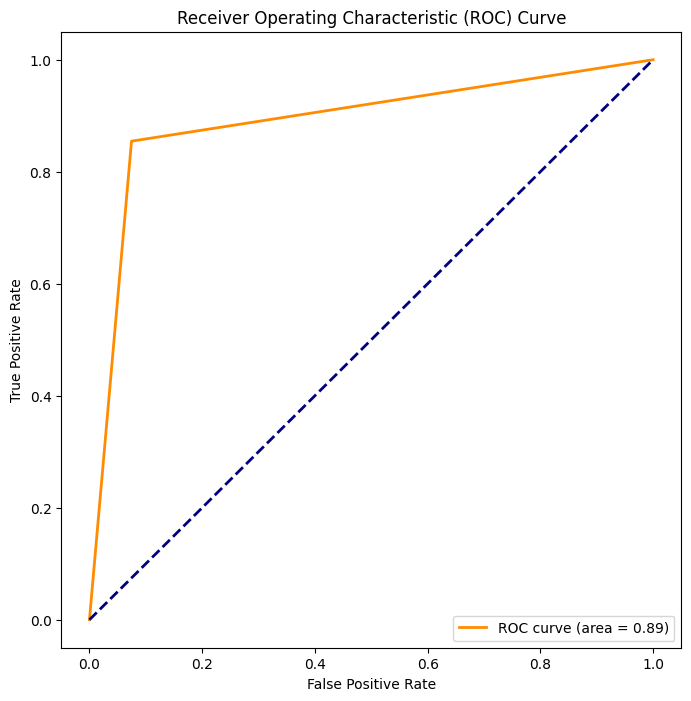

In [212]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<h2> Unseen and Different Source Text Reviews Test Set

In [233]:
from sklearn.metrics import f1_score,recall_score,precision_score
trained_classifier_model.eval()
test_predictions = []
true_labels = []

threshold = 0.35 #Adjust the threshold as needed

with torch.no_grad():
    for test_batch in  test_loader:
        
        test_input_ids, test_attention_mask, test_labels = test_batch
        test_input_ids, test_attention_mask, test_labels = test_input_ids.to(device), test_attention_mask.to(device), test_labels.to(device)
        test_outputs = trained_classifier_model(test_input_ids, attention_mask=test_attention_mask)
        predicted_class = (test_outputs[:,1] > threshold).float()
        test_predictions.extend(predicted_class.cpu().numpy())
        true_labels.extend(test_labels.cpu().numpy())

test_f1 = f1_score(true_labels, test_predictions,average = 'micro')
test_recall = recall_score(true_labels, test_predictions)
test_precision = precision_score(true_labels, test_predictions)
print(f'Test F1 Score: {test_f1:.4f}, Test Recall: {test_recall:.4f}, Test Precision: {test_precision:.4f}')

Test F1 Score: 0.4818, Test Recall: 0.6182, Test Precision: 0.4857


In [234]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, test_predictions)

# Compute AUC
auc_score = roc_auc_score(true_labels, test_predictions)
roc_auc = auc(fpr, tpr)
auc_score

0.4818181818181818

In [235]:
accuracy_score(true_labels, test_predictions)

0.4818181818181818

In [236]:
conf_matrix = confusion_matrix(true_labels,test_predictions )
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[19 36]
 [21 34]]


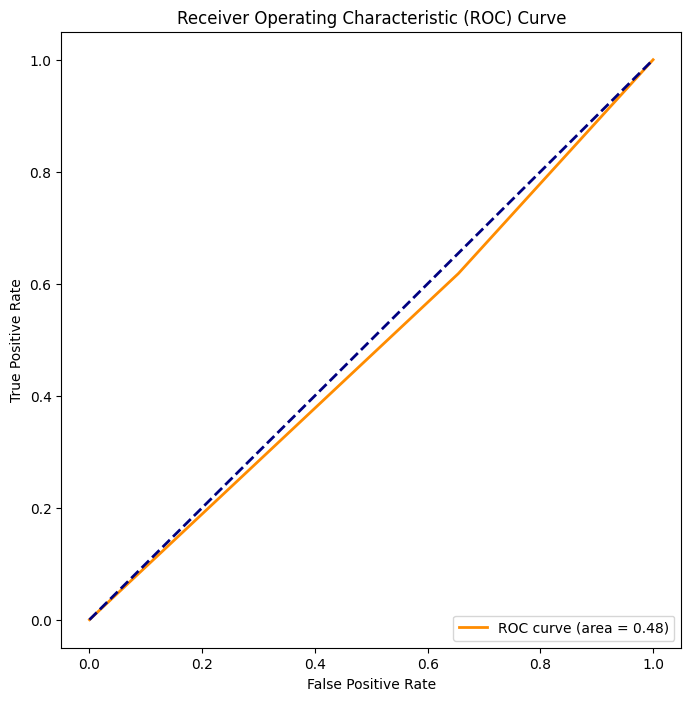

In [217]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [218]:
torch.save(trained_classifier_model.state_dict(), 'classifier.pth')